In [1]:
# imports
import numpy as np
from scipy.integrate import odeint
from scipy.stats import lognorm
import pandas as pd

import matplotlib
import pylab as pl

%matplotlib inline 
%qtconsole

# define some settings for plots
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.family'] = ['sans-serif']

In [2]:
# functions
def SSA_simulation(x_0, c, stoich_matrix, t_max):

    state = x_0
    state_path = []
    state_path.append(state)

    time = []
    time.append(0)

    tt = 0
    while tt <= t_max:
        rr = np.random.uniform(0, 1, 2)

        a_s = propensities(c, state)
        cum_a_s = np.cumsum(a_s)
        a_0 = cum_a_s[-1]

        tt = tt + 1.0 / a_0 * np.log(1.0 / rr[0])
        time.append(tt)

        prop = rr[1] * a_0

        ind = np.where(prop < cum_a_s)[0][0]

        state = state + stoich_matrix[ind]
        state_path.append(state)

    return np.array(time), np.vstack(state_path)


def propensities(c, state):
    if state[0] == 0:
        return np.array(
            [c[0], 0, 0, c[3] * state[1], c[4] * state[1], c[5] * state[2]])
    else:
        return np.array(
            [0, c[1], c[2], c[3] * state[1], c[4] * state[1], c[5] * state[2]])


def sample_SSApath_grid(ssa_time, ssa_states, time_grid):
    sampled_path = np.zeros((len(time_grid), ssa_states.shape[1]))

    for ii, time in enumerate(time_grid):
        ind = np.where(ssa_time <= time)[0][-1]
        sampled_path[ii] = ssa_states[ind]

    return sampled_path



def two_state_promoter_moments(m, t, c):
    dm = np.zeros(14)
    
    c1 = c[0]
    c2 = c[1]
    c3 = c[2]
    c4 = c[3]
    c5 = c[4]
    c6 = c[5]
    
    x_1 = m[0]
    x_2 = m[1]
    x_3 = m[2]
    x_4 = m[3]
    x_11 = m[4]
    x_12 = m[5]
    x_13 = m[6]
    x_14 = m[7]
    x_22 = m[8]
    x_23 = m[9]
    x_24 = m[10]
    x_33 = m[11]
    x_34 = m[12]
    x_44 = m[13]

    dm[0] = x_2*c2 - x_1*c1
    dm[1] = x_1*c1 - x_2*c2
    dm[2] = x_2*c3 - x_3*c4
    dm[3] = x_3*c5 - x_4*c6
    dm[4] = x_1*c1 + x_2*c2 - 2*x_11*c1 + 2*x_12*c2
    dm[5] = x_11*c1 - x_2*c2 - x_1*c1 - x_12*c1 - x_12*c2 + x_22*c2
    dm[6] = x_12*c3 - x_13*c1 - x_13*c4 + x_23*c2
    dm[7] = x_13*c5 - x_14*c1 - x_14*c6 + x_24*c2
    dm[8] = x_1*c1 + x_2*c2 + 2*x_12*c1 - 2*x_22*c2
    dm[9] = x_13*c1 + x_22*c3 - x_23*c2 - x_23*c4
    dm[10] = x_14*c1 - x_24*c2 + x_23*c5 - x_24*c6
    dm[11] = x_2*c3 + x_3*c4 + 2*x_23*c3 - 2*x_33*c4
    dm[12] = x_24*c3 + x_33*c5 - x_34*c4 - x_34*c6
    dm[13] = x_3*c5 + x_4*c6 + 2*x_34*c5 - 2*x_44*c6
    
    return dm

# Gene expression in single cells is stochastic

In [3]:
path = '/Users/baumgaer/ownCloud/SummerSchool/MatlabCode/Data/'

DCS2 = pd.read_csv(path+'YFPDCS2.csv')
time = np.array(DCS2.iloc[:,0])
DCS2 = np.array(DCS2.iloc[:,1:])

SIP18 = pd.read_csv(path+'YFPSIP18.csv')
SIP18 = np.array(SIP18.iloc[:,1:])

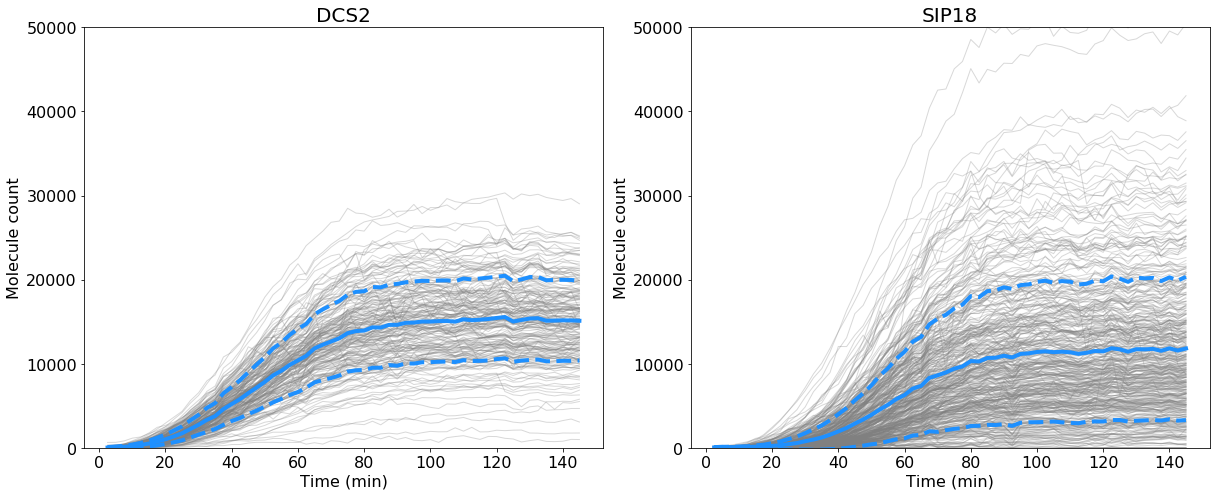

In [4]:
fig,ax = pl.subplots(1,2, figsize = (17,7))

ax[0].plot(time/60,DCS2, color = 'grey',alpha = 0.3, lw = 1);
ax[0].plot(time/60,DCS2.mean(1), color = 'dodgerblue', lw = 4)
ax[0].plot(time/60,DCS2.mean(1)+DCS2.std(1),'--', color = 'dodgerblue', lw = 4)
ax[0].plot(time/60,DCS2.mean(1)-DCS2.std(1),'--', color = 'dodgerblue', lw = 4)
ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Molecule count')
ax[0].set_title('DCS2', fontsize = 20)
ax[0].set_ylim(0,50000)

ax[1].plot(time/60,SIP18, color = 'grey',lw = 1, alpha = 0.3);
ax[1].plot(time/60,SIP18.mean(1), color = 'dodgerblue', lw = 4)
ax[1].plot(time/60,SIP18.mean(1)+SIP18.std(1),'--', color = 'dodgerblue', lw = 4)
ax[1].plot(time/60,SIP18.mean(1)-SIP18.std(1),'--', color = 'dodgerblue', lw = 4)
ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Molecule count')
ax[1].set_title('SIP18', fontsize = 20)
ax[1].set_ylim(0,50000)

pl.tight_layout()

## A simple birth death process

In [5]:
x_0 = np.zeros(3)
x_0[0] = 1

c = np.array([
    0.00,  # gene activation rate
    0.0,  # gene inactivation rate
    0.5,  # transcription rate
    0.005,  # RNA degradation rate
    0.1,  # RNA translation rate
    0.05,  # protein degradation rate
])

stoich_matrix = np.array([[1, 0, 0], 
                          [-1, 0, 0],
                          [0, 1, 0], 
                          [0, -1, 0],
                          [0, 0, 1], 
                          [0, 0, -1]])

t_max = 150*60

In [6]:
time,states = SSA_simulation(x_0,c, stoich_matrix,t_max)

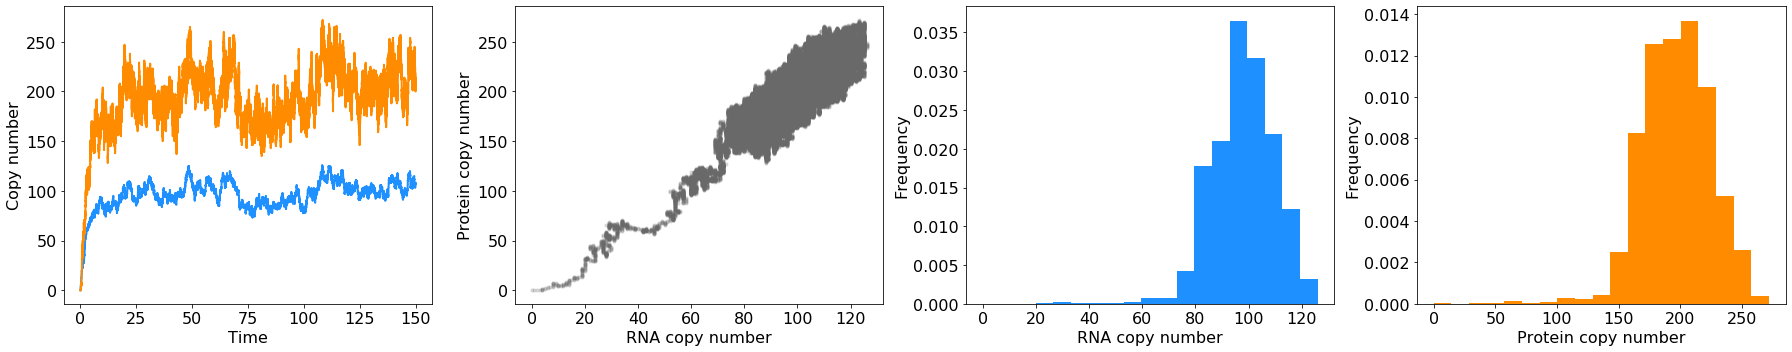

In [7]:
fig,ax = pl.subplots(1,4, figsize = (25,5))

ax[0].plot(time/60,states[:,1], lw = 2, color = 'dodgerblue')
ax[0].plot(time/60,states[:,2], lw = 2, color = 'darkorange')

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Copy number")

ax[1].scatter(states[:,1],states[:,2], c = 'dimgrey', s = 10, alpha = 0.2)
ax[1].set_xlabel('RNA copy number')
ax[1].set_ylabel('Protein copy number')

bins = np.linspace(0,states[:,1].max(),20)
ax[2].hist(states[:,1],bins = bins, color = 'dodgerblue', density = True);
ax[2].set_xlabel('RNA copy number')
ax[2].set_ylabel('Frequency')

bins = np.linspace(0,states[:,2].max(),20)
ax[3].hist(states[:,2], bins = bins, color = 'darkorange', density = True);
ax[3].set_xlabel('Protein copy number')
ax[3].set_ylabel('Frequency')

pl.tight_layout()

## The two state promoter model

**Some literature:**
1. Raj, A., Peskin, C. S., Tranchina, D., Vargas, D. Y. & Tyagi, S. Stochastic mRNA synthesis in mammalian cells. PLoS Biol. 4, e309 (2006).
2. Coulon, A., Chow, C. C., Singer, R. H. & Larson, D. R. Eukaryotic transcriptional dynamics: from single molecules to cell populations. Nat. Rev. Genet. 14, 572–84 (2013).

# Stochastic simulations to model stochastic gene expression

## Reactions

Gene switching $$ On \xrightarrow{k_{off}} Off$$
$$ On \xleftarrow{k_{on}} Off$$
RNA transcription, when the gene is on
$$ RNA \xrightarrow{k_{txn}} RNA + 1 $$
RNA degradation
$$ RNA \xrightarrow{\gamma_{RNA}\cdot RNA} RNA -1$$
Protein production
$$ protein \xrightarrow{k_{tl}*RNA} protein + 1$$
Protein degradation
$$protein \xrightarrow{\gamma_{protein} \cdot protein} protein -1$$

## The chemical master equation

## SSA or Gillespie algorithm

1. Initialise the system at t = 0: rate constants $c$ and initial molecule copy numbers
2. Calculate indiviual reaction hazards $h_{i}(x,c_{i})$ based on current state
3. Calculate $h_{0}(c,x) = \sum_{i}h_{i}(x,c_{i}$
4. Simulate next time to next event, $t'$ as an $Exp[h_{0}(x,c)]$ quantity and put time to $t:=t+t'$
5. Simulate the reaction 

**Some literature**

1. Gillespie, D. T. A rigorous derivation of the chemical master equation. Phys. A Stat. Mech. its Appl. 188, 404–425 (1992).

2. Gillespie, D. T. Exact stochastic simulation of coupled chemical reactions. J. Phys. Chem. 93555, 2340–2361 (1977).

3. Gillespie, D. T. Stochastic simulation of chemical kinetics. Annu. Rev. Phys. Chem. 58, 35–55 (2007).

In [47]:
# initialise
x_0_ssa = np.zeros(3)

c = np.array([
    0.002,  # gene activation rate
    0.009,  # gene inactivation rate
    0.5,  # transcription rate
    0.005,  # RNA degradation rate
    0.1,  # RNA translation rate
    0.005,  # protein degradation rate
])

stoich_matrix = np.array([[1, 0, 0], 
                          [-1, 0, 0],
                          [0, 1, 0], 
                          [0, -1, 0],
                          [0, 0, 1], 
                          [0, 0, -1]])
t_max = 150*60

In [34]:
# single realisation
time,states = SSA_simulation(x_0_ssa,c,stoich_matrix,10000)

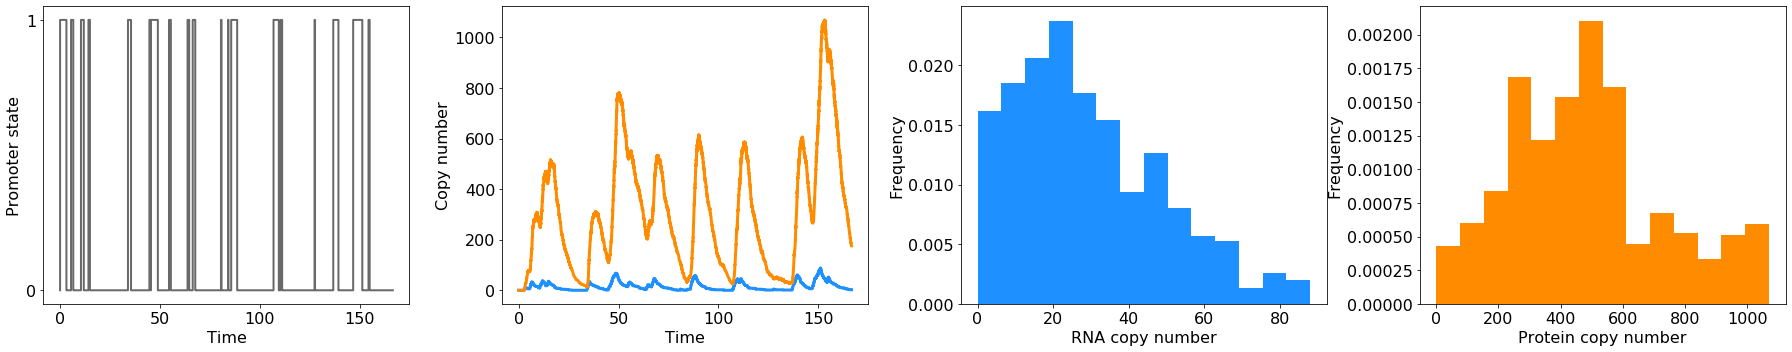

In [35]:
fig, ax = pl.subplots(1, 4, figsize=(25, 5))

ax[0].plot(time/60, states[:, 0], lw=2, color="dimgrey", drawstyle="steps-pre")

ax[0].set_xlabel("Time")
ax[0].set_yticks([0, 1])
ax[0].set_ylabel("Promoter state")

ax[1].plot(time/60, states[:, 1], lw=3, color="dodgerblue")
ax[1].plot(time/60, states[:, 2], lw=3, color="darkorange")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Copy number")

bins = np.linspace(0,states[:,1].max(),15)
ax[2].hist(states[:,1],bins = bins, color = 'dodgerblue', density = True);
ax[2].set_xlabel('RNA copy number')
ax[2].set_ylabel('Frequency')

bins = np.linspace(0,states[:,2].max(),15)
ax[3].hist(states[:,2], bins = bins, color = 'darkorange', density = True);
ax[3].set_xlabel('Protein copy number')
ax[3].set_ylabel('Frequency')

pl.tight_layout()

# Moment equations

**Some literature**
1. Zechner, C. et al. Moment-based inference predicts bimodality in transient gene expression. Proc. Natl. Acad. Sci. 109, 8340–8345 (2012).

In [156]:
x_0_moments = np.zeros(14)
x_0_moments[0] = 1
x_0_moments[4] = 1

time_grid = np.linspace(0.1, t_max, 150)

moments = odeint(two_state_promoter_moments,x_0_moments,time_grid,args = (c,))

p_on = moments[:,1]
RNA_mean_m = moments[:,2]
protein_mean_m = moments[:,3]
RNA_var_m = moments[:,11] - RNA_mean_m**2
protein_var_m = moments[:,13] - protein_mean_m**2

In [157]:
# average over SSA runs to obtain means and variances
repeats = 100
sims = np.zeros((repeats, len(time_grid), 3))

for ii in np.arange(repeats):
    ssa_time, ssa_states = SSA_simulation(x_0_ssa, c, stoich_matrix, t_max)

    sims[ii] = sample_SSApath_grid(ssa_time, ssa_states, time_grid)

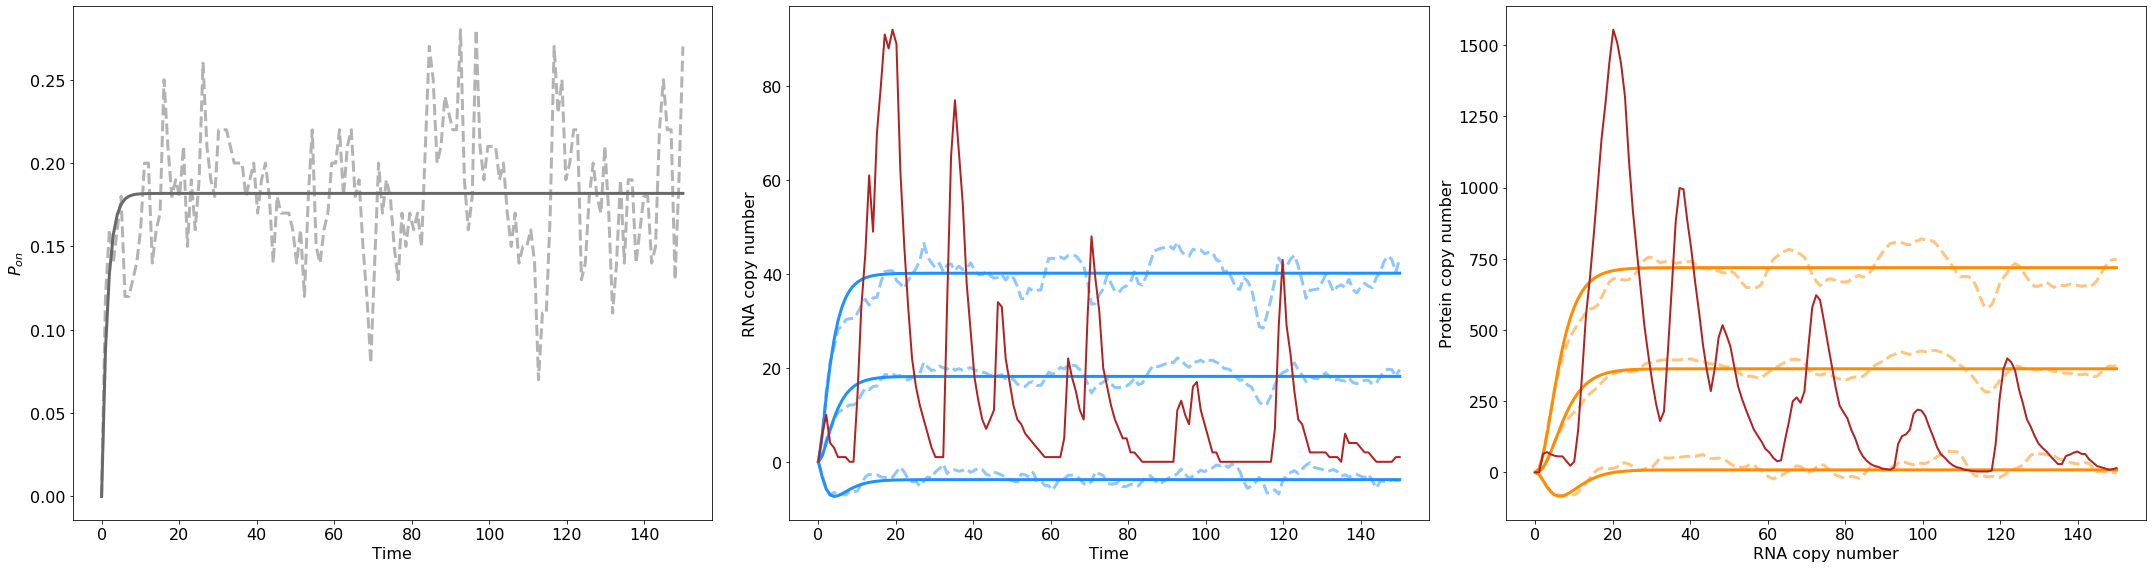

In [158]:
# plot
fig, ax = pl.subplots(1, 3, figsize=(30, 8))

ind_single = 14

means = sims.mean(0)
stds = sims.std(0)

ax[0].plot(time_grid / 60, means[:, 0], "--", lw=3, color="dimgrey", alpha=0.5)
ax[0].plot(time_grid / 60, p_on, lw=3, color="dimgrey")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("$P_{on}$")

ax[1].plot(time_grid / 60, RNA_mean_m, lw=3, color="dodgerblue")
ax[1].plot(time_grid / 60, RNA_mean_m + RNA_var_m ** 0.5, lw=3, color="dodgerblue")
ax[1].plot(time_grid / 60, RNA_mean_m - RNA_var_m ** 0.5, lw=3, color="dodgerblue")
ax[1].plot(time_grid / 60, means[:, 1], "--", lw=3, color="dodgerblue", alpha=0.5)
ax[1].plot(
    time_grid / 60, means[:, 1] + stds[:, 1], "--", lw=3, color="dodgerblue", alpha=0.5
)
ax[1].plot(
    time_grid / 60, means[:, 1] - stds[:, 1], "--", lw=3, color="dodgerblue", alpha=0.5
)
ax[1].plot(time_grid / 60, sims[ind_single, :, 1], lw=2, color="firebrick")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("RNA copy number")

ax[2].plot(time_grid / 60, protein_mean_m, lw=3, color="darkorange")
ax[2].plot(
    time_grid / 60, protein_mean_m + protein_var_m ** 0.5, lw=3, color="darkorange"
)
ax[2].plot(
    time_grid / 60, protein_mean_m - protein_var_m ** 0.5, lw=3, color="darkorange"
)

ax[2].plot(time_grid / 60, means[:, 2], "--", lw=3, color="darkorange", alpha=0.5)
ax[2].plot(
    time_grid / 60, means[:, 2] + stds[:, 2], "--", lw=3, color="darkorange", alpha=0.5
)
ax[2].plot(
    time_grid / 60, means[:, 2] - stds[:, 2], "--", lw=3, color="darkorange", alpha=0.5
)
ax[2].plot(time_grid / 60, sims[ind_single, :, 2], lw=2, color="firebrick")
ax[2].set_ylabel("Protein copy number")
ax[2].set_xlabel("RNA copy number")

pl.tight_layout()

# Fitting moments to synthetic gene expression data

## MCMC based model fitting

In [188]:
# functions
def bootstrap_moments(data, n_samples):
    size = data.shape[1]
    cells = np.arange(data.shape[0])

    moments = np.zeros((size, 2))
    uncertainties = np.zeros((size, 3))

    for ii in np.arange(size):

        means = np.zeros(n_samples)
        sec_order = np.zeros(n_samples)
        stds = np.zeros(n_samples)

        for jj in np.arange(n_samples):
            ind = np.random.choice(cells, cells.shape[0], replace=True)

            means[jj] = data[ind, ii].mean()
            sec_order[jj] = np.mean(data[ind, ii] ** 2)

        moments[ii, 0] = means.mean()
        moments[ii, 1] = sec_order.mean()

        cov = np.cov(means, sec_order)
        uncertainties[ii, 0] = cov[0, 0]
        uncertainties[ii, 1] = cov[1, 1]
        uncertainties[ii, 2] = cov[0, 1]

    return moments, uncertainties


def evaluate_log_likelihood(data, model, uncertainties):
    log_l = 0

    for ii in np.arange(len(data)):
        mu = model[ii]
        y = data[ii]

        dd = (mu - y).reshape(2, 1)

        sigma[0, 0] = np.copy(uncertainties[ii, 0])
        sigma[1, 1] = np.copy(uncertainties[ii, 1])

        if np.sum(np.diag(sigma) > 0) > 1:
            sigma_inv = np.linalg.inv(sigma)

            distance = np.dot(np.dot(dd.transpose(), sigma_inv), dd)[0, 0]

            log_l = log_l - distance

    return log_l


In [163]:
# bootstrap moments and uncertainties
n_samples = 1000
data = sims[:, :, 2]

moments_data, uncertainties_data = bootstrap_moments(data, n_samples)
protein_mean = moments_data[:, 0]
protein_var = moments_data[:, 1] - moments_data[:, 0] ** 2

In [261]:
# running actual MCMC
n_iter = 5000
unknown_rates = np.array([0, 1, 2, 4], dtype=int)

chain = np.zeros((n_iter, len(unknown_rates)))
chain[0] = 0.01

sigma_prop = 0.02

acc_count = 0
l_vec = np.zeros(n_iter - 1)

for ii in np.arange(1, n_iter):
    current_param = chain[ii - 1]

    prop_param = np.random.lognormal(np.log(current_param), sigma_prop)

    log_forward_prop = np.sum(
        lognorm.pdf(np.exp(prop_param), sigma_prop, 0, np.exp(current_param))
    )
    log_backward_prop = np.sum(
        lognorm.pdf(np.exp(current_param), sigma_prop, 0, np.exp(prop_param))
    )

    c_temp = np.copy(c)
    c_temp[unknown_rates] = prop_param
    moments = odeint(two_state_promoter_moments, x_0_moments, time_grid, args=(c_temp,))

    moments_model = moments[:, np.array([3, 13])]

    l_new = evaluate_log_likelihood(moments_data, moments_model, uncertainties_data)

    if ii == 1:
        accept = 1
    else:
        accept = np.min(
            [1, np.exp(l_new - l_old + log_backward_prop - log_forward_prop)]
        )

    if accept >= np.random.uniform(0, 1, 1):
        chain[ii] = prop_param
        l_old = l_new

        acc_count = acc_count + 1

    else:
        chain[ii] = chain[ii - 1]

    l_vec[ii - 1] = l_old

Text(0, 0.5, 'Protein copy number')

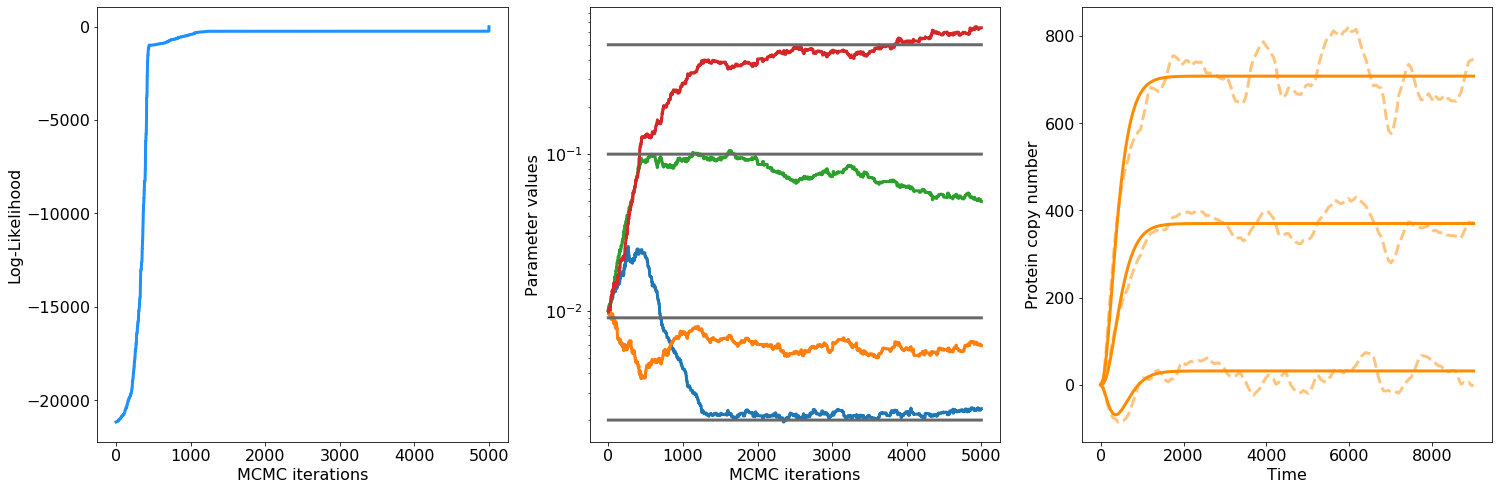

In [262]:
fig, ax = pl.subplots(1, 3, figsize=(25, 8))

ax[0].plot(l_vec, lw=3, color="dodgerblue")
ax[0].set_xlabel("MCMC iterations")
ax[0].set_ylabel("Log-Likelihood")

ax[1].plot(chain, lw=3)
ax[1].plot(np.zeros_like(chain) + c[unknown_rates], lw=3, color="dimgrey")
ax[1].set_xlabel("MCMC iterations")
ax[1].set_ylabel("Parameter values")
ax[1].set_yscale("log")

ax[2].plot(time_grid, protein_mean, "--", lw=3, color="darkorange", alpha=0.5)
ax[2].plot(
    time_grid,
    protein_mean + protein_var ** 0.5,
    "--",
    lw=3,
    color="darkorange",
    alpha=0.5,
)
ax[2].plot(
    time_grid,
    protein_mean - protein_var ** 0.5,
    "--",
    lw=3,
    color="darkorange",
    alpha=0.5,
)
ax[2].plot(time_grid, moments_model[:, 0], lw=3, color="darkorange")
ax[2].plot(
    time_grid,
    moments_model[:, 0] - np.sqrt(moments_model[:, 1] - moments_model[:, 0] ** 2),
    lw=3,
    color="darkorange",
)
ax[2].plot(
    time_grid,
    moments_model[:, 0] + np.sqrt(moments_model[:, 1] - moments_model[:, 0] ** 2),
    lw=3,
    color="darkorange",
)

ax[2].set_xlabel("Time")
ax[2].set_ylabel("Protein copy number")

## Analyse posterior

# Fitting moments of actual gene expression data